In [1]:
import numpy as np 
import mdtraj as md
from molecular_mpns.config import data_dir, fig_dir
from molecular_mpns.vae import VAE, VAEloss
from molecular_mpns.data import AlanineDipeptideGraph
from torch_geometric.data import DataLoader
from molecular_mpns.training_utils import *
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ExponentialLR
import os

In [2]:
# load training trajectory
os.chdir(data_dir)
os.chdir('alanine_dipeptide/')
xtc_file = 'alanine-dipeptide-0-250ns-nowater.xtc'
top_file = 'alanine-dipeptide-nowater.pdb'
traj = md.load(xtc_file,top=top_file)

In [3]:
# create graphs
z = [atom.element.atomic_number for atom in traj.topology.atoms]
G = [AlanineDipeptideGraph(z = torch.tensor(z).long(),pos = torch.tensor(xyz)) for xyz in traj.xyz]

In [21]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_spherical': 16, 'num_radial': 6, 'hidden_channels': 128, 'num_bilinear': 4, 'out_channels': 64, 'num_layers': 2, 'num_blocks': 2,
         'num_enc_lins': 4, 'num_dec_lins': 4, 'enc_act': torch.tanh, 'dec_act': torch.tanh, 'dec_hidden_channels': 128, 'dec_var_const': False,
         'cutoff': 0.5, 'zdim': 2}

mod = VAE(**kwargs)
mod = mod.to(device)

opt = torch.optim.Adam(mod.parameters(),lr = 1e-3, weight_decay = 1e-5)
sched = ExponentialLR(opt, gamma = 0.995)

Epoch 1 Loss: 12419.735229492188


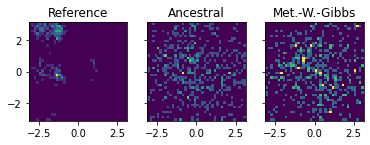

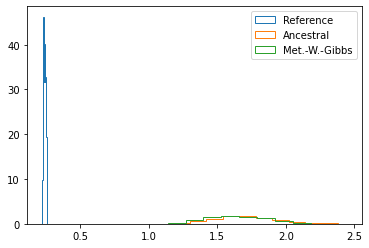

Epoch 2 Loss: 808.3446960449219


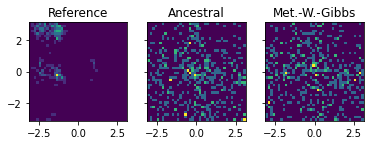

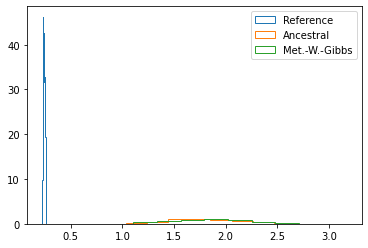

Epoch 3 Loss: -7478.828918457031


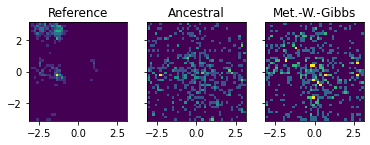

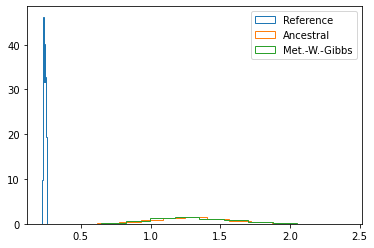

Epoch 4 Loss: -15862.450927734375


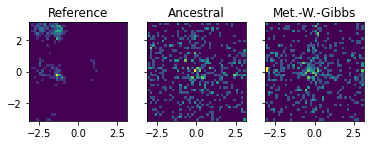

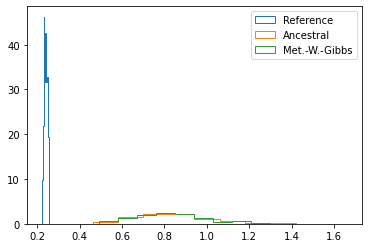

Epoch 5 Loss: -23429.514404296875


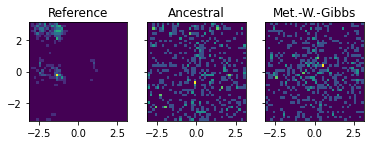

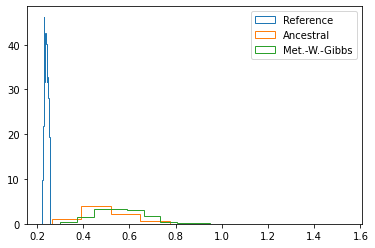

Epoch 6 Loss: -28597.4091796875


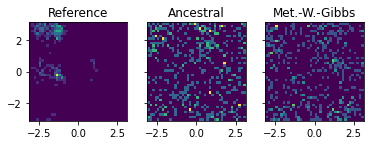

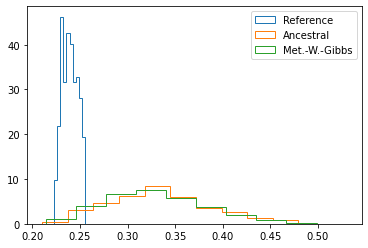

Epoch 7 Loss: -32225.61572265625


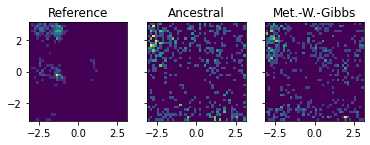

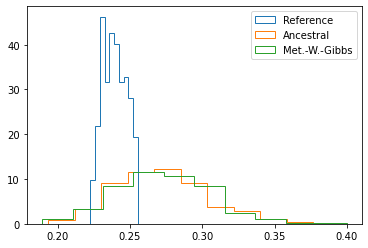

Epoch 8 Loss: -35211.93408203125


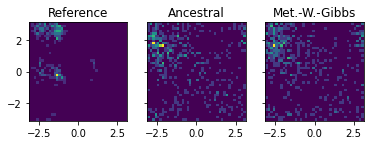

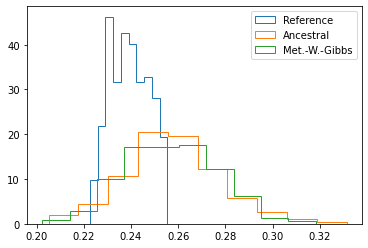

Epoch 9 Loss: -37032.6748046875


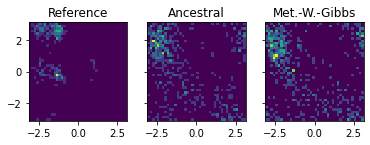

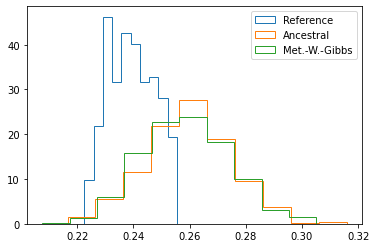

Epoch 10 Loss: -37996.288818359375


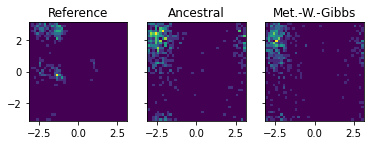

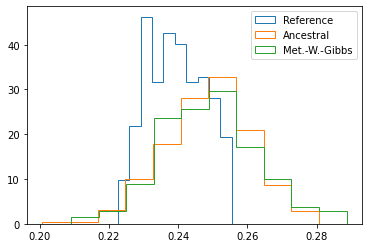

Epoch 11 Loss: -38166.846435546875


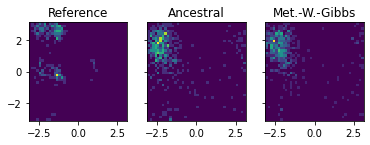

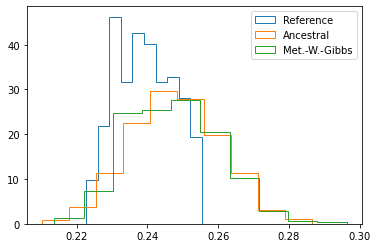

Epoch 12 Loss: -37999.433349609375


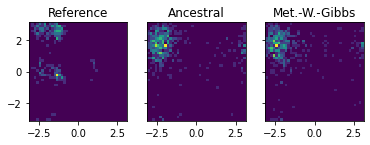

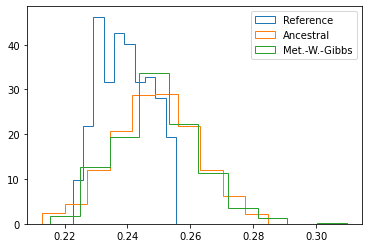

Epoch 13 Loss: -38580.14208984375


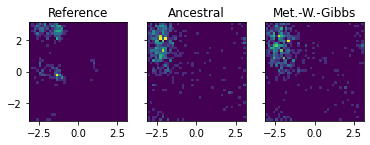

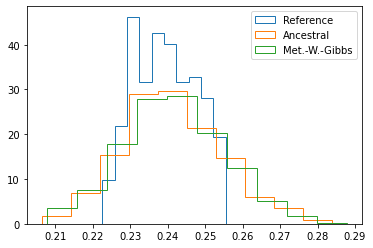

Epoch 14 Loss: -38956.142822265625


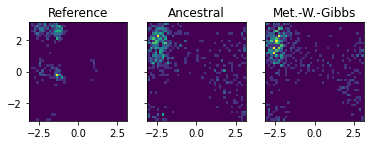

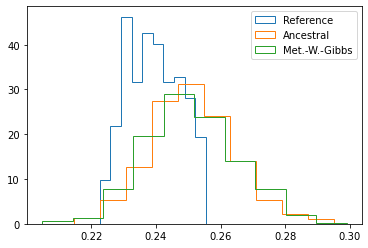

Epoch 15 Loss: -38959.1416015625


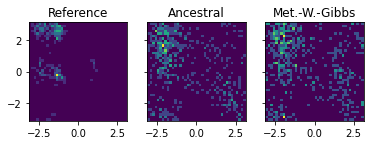

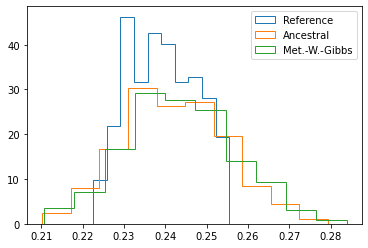

Epoch 16 Loss: -39256.25634765625


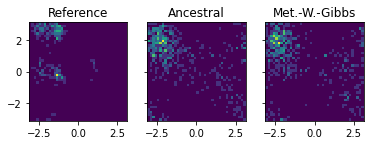

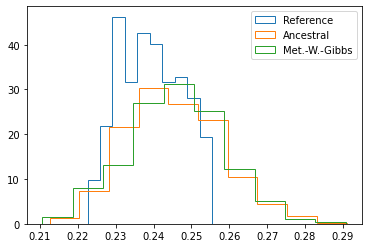

Epoch 17 Loss: -39409.532958984375


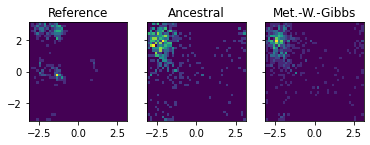

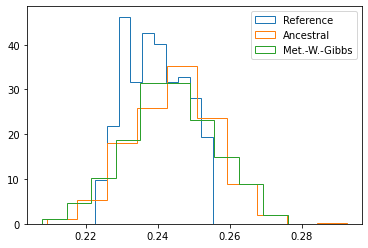

Epoch 18 Loss: -39348.72216796875


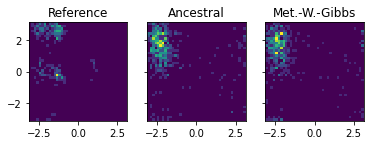

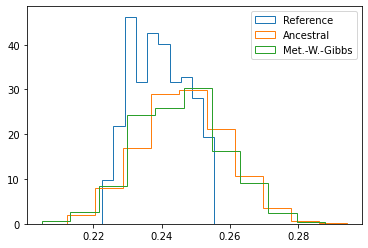

Epoch 19 Loss: -38522.365234375


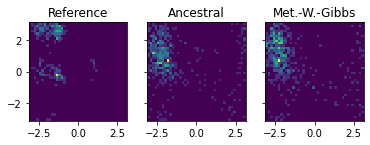

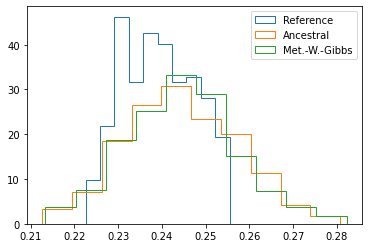

Epoch 20 Loss: -39281.462158203125


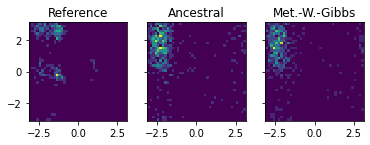

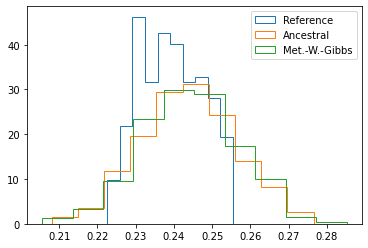

Epoch 21 Loss: -39427.82861328125


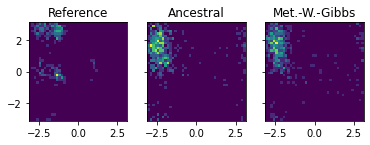

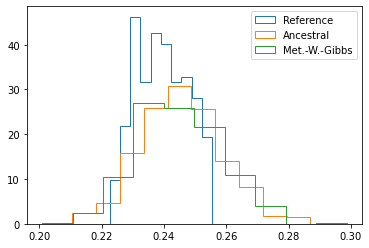

Epoch 22 Loss: -38692.31640625


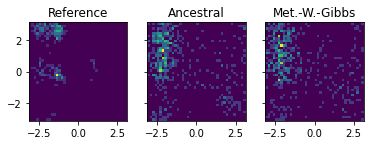

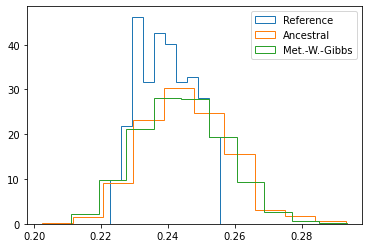

Epoch 23 Loss: -38980.469482421875


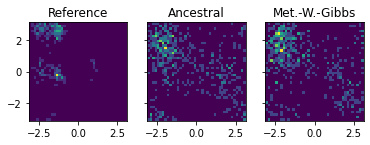

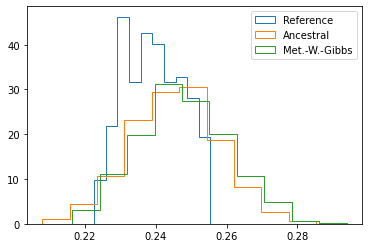

Epoch 24 Loss: -39219.03857421875


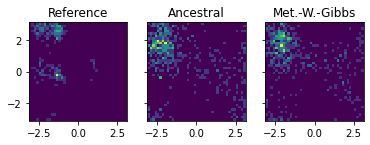

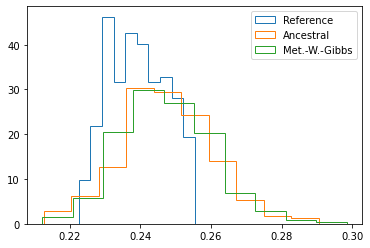

Epoch 25 Loss: -39355.9130859375


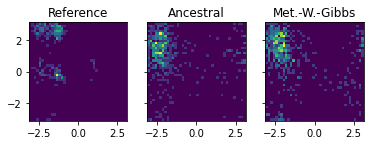

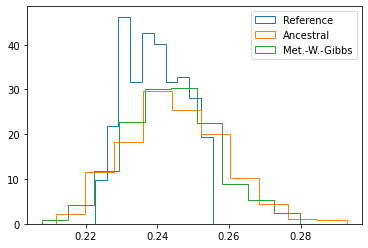

Epoch 26 Loss: -39560.78466796875


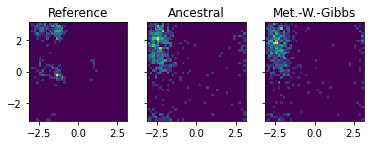

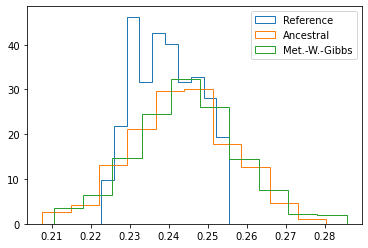

Epoch 27 Loss: -39593.10986328125


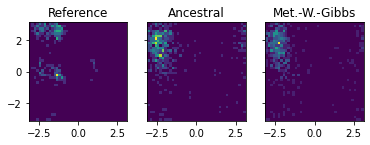

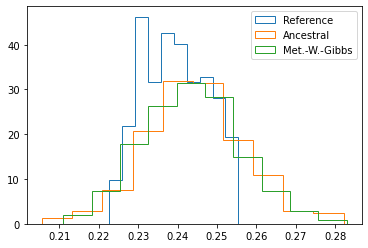

Epoch 28 Loss: -38495.314453125


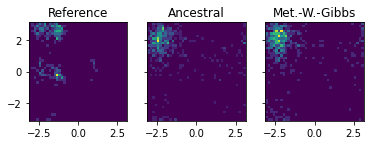

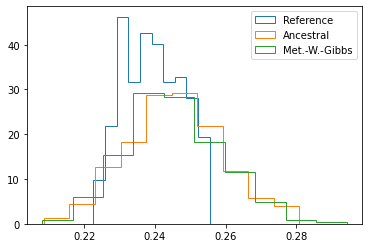

Epoch 29 Loss: -38945.188232421875


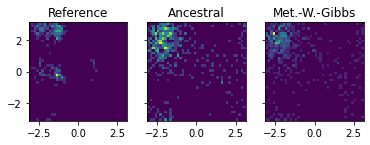

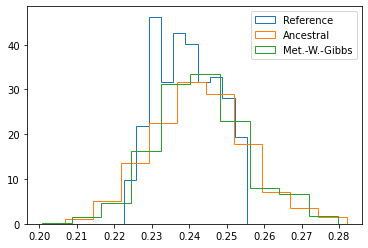

Epoch 30 Loss: -39403.6162109375


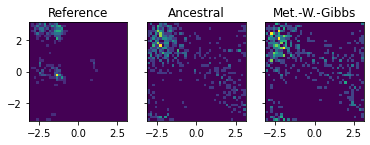

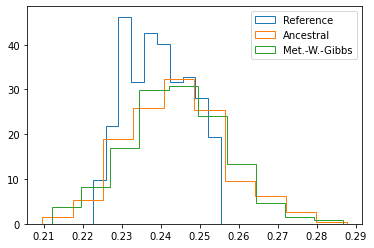

In [22]:
# training loop
os.chdir(fig_dir)
epochs, batch_size = 30, 32
subset_size, train_prop  = 500, 0.5

train, test = train_test_split(data = G,subset_size = subset_size, train_prop = train_prop)
traj_xyz_ref = np.array([mol.pos.cpu().numpy() for mol in train])

for ep in range(epochs):
    ep_loss = 0
    
    # downsample training set
    np.random.seed(42)
    random_idx = np.random.choice(len(train),len(train), replace = False)
    G_epoch = [train[i] for i in random_idx]
    loader = DataLoader(G_epoch,batch_size = batch_size)
    
    for G_batch in loader:
        G_batch.to(device)
        
        # forward pass
        recon_batch, mu_enc, logvar_enc = mod(G_batch)
        mu_dec = recon_batch[0]
        logvar_dec = recon_batch[1]
        
        # compute loss
        loss = VAEloss(mu_dec,logvar_dec,G_batch,mu_enc,logvar_enc,L=1)
        
        # back prop
        loss.backward()
        opt.step()
        opt.zero_grad()
        ep_loss += loss.item()
    
    if (ep+1) % 1 == 0:
        
        # ancestral sampling
        traj_xyz_ancestral = ancestral_sample(mod = mod , T = subset_size, dim_z = kwargs['zdim'],device = device)
    
        print("Epoch " + str(ep + 1) + " Loss: " + str(ep_loss))
        z0 = torch.randn((1,kwargs['zdim'])).to(device)
        x0 = train[0].pos
        traj_xyz_mwg = np.zeros((subset_size,22,3))

        for t in range(subset_size):
            z0, x0 = mod.mwg_sample(z0, x0, atomic_numbers = z)
            traj_xyz_mwg[t,:,:] = x0.cpu().numpy()
            
        
        dihedrals_ref, dihedrals_ancestral, dihedrals_mwg = compare_dihedrals(traj_xyz_ref, traj_xyz_ancestral, traj_xyz_mwg ,topology = traj.topology)
        rogs_ref, rogs_ancestral, rogs_mwg = compare_rogs(traj_xyz_ref, traj_xyz_ancestral, traj_xyz_mwg ,topology = traj.topology)